# Graphene

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import junpy as jp
from junpy.factory import tightbinding
%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.rc = {'font.size': 12}

## Build Device

In [7]:
t = np.eye(2)*2.8
e0 = np.eye(2)*0
sin30, cos30 = 1/2, np.sqrt(3)/2

# define positions and lattice vectors
acc = 1.42  # [ang] carbon-carbon distance
a1 = [2*acc*cos30,               0.0,     0.0]
a2 = [        0.0, 2*acc+2*acc*sin30,     0.0]
a3 = [        0.0,               0.0,     0.0]
basis1 = [      0.0,                 0.0, 0.0]
basis2 = [acc*cos30, basis1[1]+acc*sin30, 0.0]
basis3 = [acc*cos30, basis2[1]+acc      , 0.0]
basis4 = [      0.0, basis3[1]+acc*sin30, 0.0]

# create center
builder = tightbinding.DeviceBuilder([a1, a2, a3], 'CollinearSpin')
builder.set_translationSymmetry(False, True, False)
builder.add_site('s1', basis1, e0)
builder.add_site('s2', basis2, e0)
builder.add_site('s3', basis3, e0)
builder.add_site('s4', basis4, e0)
builder.add_hopping('s1', ((0,0,0), 's2'), -t)
builder.add_hopping('s2', ((0,0,0), 's3'), -t)
builder.add_hopping('s3', ((0,0,0), 's4'), -t)
builder.add_hopping('s4', ((0,1,0), 's1'), -t)

# create lead
lead = tightbinding.DeviceBuilder([a1, a2, a3], 'CollinearSpin')
lead.set_translationSymmetry(True, True, False)
lead.add_site('f1', basis1, e0)
lead.add_site('f2', basis2, e0)
lead.add_site('f3', basis3, e0)
lead.add_site('f4', basis4, e0)
lead.add_hopping('f1', ((0,0,0), 'f2'), -t)
lead.add_hopping('f2', ((0,0,0), 'f3'), -t)
lead.add_hopping('f3', ((0,0,0), 'f4'), -t)
lead.add_hopping('f4', ((0,1,0), 'f1'), -t)
lead.add_hopping('f2', ((1,0,0), 'f1'), -t)
lead.add_hopping('f3', ((1,0,0), 'f4'), -t)

# attach left lead
builder.attach_lead('left', lead, -1)
builder.add_lead_coupling('s1', 'left', (0,0,0), 'f2', -t)
builder.add_lead_coupling('s4', 'left', (0,0,0), 'f3', -t)

# attach right lead
builder.attach_lead('right', lead, +1)
builder.add_lead_coupling('s2', 'right', (0,0,0), 'f1', -t)
builder.add_lead_coupling('s3', 'right', (0,0,0), 'f4', -t)

device = builder.create_device()

## Calculate Density of States

In [3]:
calcr_dos = jp.DensityOfStates(
    device=device,
    energies=np.linspace(-10, 10, 101),
    kpoints=jp.SymmetryKspaceSampling((1,101,1)),
    etaSigma=0.05)
jp.run(calcr_dos, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating density of states... (2024-08-14 21:12:39)
    Device information
        bias (mu2-mu1)--------------------------: 0
        central.numberOfSites-------------------: 4
        central.spinType------------------------: SpinType.CollinearSpin
        lead1.numberOfSites---------------------: 4
        lead1.spinType--------------------------: SpinType.CollinearSpin
        lead1.direction-------------------------: -1
        lead1.temperature-----------------------: 0
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 4
        lead2.spinType--------------------------: SpinType.Collinear

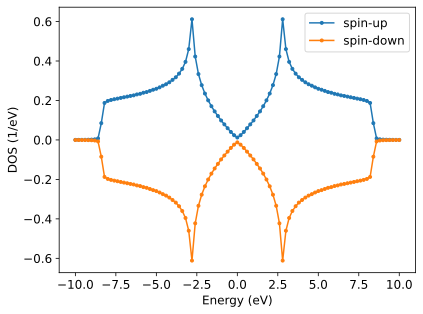

In [4]:
# shape: (#kpoints, #energies, #spin)
dos = calcr_dos.densityOfStates(spin='diag')

plt.plot(calcr_dos.energies,  dos[0,:,0], '.-', label='spin-up')
plt.plot(calcr_dos.energies, -dos[0,:,1], '.-', label='spin-down')
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (1/eV)')
plt.legend()
plt.show()

## Calculate Transmission

In [5]:
calcr_trans = jp.Transmission(
    device=device,
    energies=np.linspace(-10, 10, 101),
    kpoints=jp.SymmetryKspaceSampling((1,101,1)),
    etaSigma=1e-4)
jp.run(calcr_trans, savefile=False)

JunPy version---------------------------: 0.15.0.post29+ga5b3260
Parallelization information
    BLAS Vendor-----------------------------: MKL
    Total number of MPI processes-----------: 1
    OMP_NUM_THREADS-------------------------: 1
    MKL_NUM_THREADS-------------------------: unset
    OPENBLAS_NUM_THREADS--------------------: unset
Calculating transmission... (2024-08-14 21:12:59)
    Device information
        bias (mu2-mu1)--------------------------: 0
        central.numberOfSites-------------------: 4
        central.spinType------------------------: SpinType.CollinearSpin
        lead1.numberOfSites---------------------: 4
        lead1.spinType--------------------------: SpinType.CollinearSpin
        lead1.direction-------------------------: -1
        lead1.temperature-----------------------: 0
        lead1.chemicalPotential-----------------: 0
        lead2.numberOfSites---------------------: 4
        lead2.spinType--------------------------: SpinType.CollinearSpin


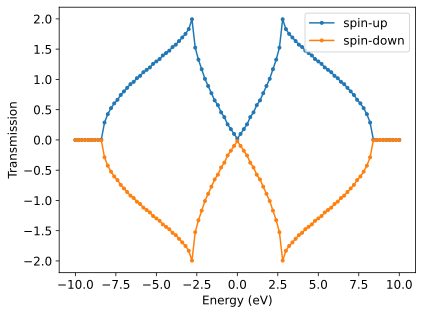

In [6]:
# shape: (#kpoints, #energies, #spin)
trans = calcr_trans.transmission(spin='diag')

plt.plot(calcr_trans.energies,  trans[0,:,0], '.-', label='spin-up')
plt.plot(calcr_trans.energies, -trans[0,:,1], '.-', label='spin-down')
plt.xlabel('Energy (eV)')
plt.ylabel('Transmission')
plt.legend()
plt.show()